<a href="https://colab.research.google.com/github/rafael2673/AEDII/blob/main/U1T3/trabalho3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 3

Data with regular medicines registered in Brazil.

In [52]:
# Data with regular medicines registered in Brazil.
import pandas as pd
from IPython.display import display, HTML
try:
  df = pd.read_csv('/content/sample_data/DADOS_ABERTOS_MEDICAMENTOS.csv', encoding='ISO-8859-1', sep=';')
  display(HTML(df.head(10).to_html()))
except FileNotFoundError:
  print("File 'DADOS_ABERTOS_MEDICAMENTOS.csv' not found. Please make sure the file is in the same directory or provide the correct path.")
except Exception as e:
  print(f"An error occurred: {e}")


,TIPO_PRODUTO,NOME_PRODUTO,DATA_FINALIZACAO_PROCESSO,CATEGORIA_REGULATORIA,NUMERO_REGISTRO_PRODUTO,DATA_VENCIMENTO_REGISTRO,NUMERO_PROCESSO,CLASSE_TERAPEUTICA,EMPRESA_DETENTORA_REGISTRO,SITUACAO_REGISTRO,PRINCIPIO_ATIVO
0,MEDICAMENTO,(VITAMINAS A ) + ASSSOCIACÕES,25/04/2000,SIMILAR,104540166.0,01/04/2005,250000254169821,VITAMINAS E SUPLEMENTOS MINERAIS,60874187000184 - DAIICHI SANKYO BRASIL FARMACÊUTICA LTDA,CADUCO/CANCELADO,NaN
1,MEDICAMENTO,AC SALICILICO + AC BENZOICO + IODO,19/05/2000,SIMILAR,119350001.0,01/05/2005,2501017185899,ANTIMICOTICOS PARA USO TOPICO,63826069000199 - LABORATORIO FLORA DA AMAZONIA LTDA,CADUCO/CANCELADO,NaN
2,MEDICAMENTO,ALENDRONATO SODICO,04/06/2001,SIMILAR,100470305.0,01/05/2006,253510228050056,SUPRESSORES DA REABSORCAO OSSEA,61286647000116 - SANDOZ DO BRASIL INDÚSTRIA FARMACÊUTICA LTDA,CADUCO/CANCELADO,NaN
3,MEDICAMENTO,ARNICA MONTANA,19/03/2002,FITOTERÁPICO,104730021.0,01/03/2007,2502500782199,FITOTERAPICO SIMPLES,92762277000170 - VIDORA FARMACÊUTICA LTDA,CADUCO/CANCELADO,NaN
4,MEDICAMENTO,ARNICA MONTANA L.,01/07/2002,FITOTERÁPICO,131750004.0,01/06/2007,253510326310184,FITOTERAPICO SIMPLES,00925697000101 - LIMED LABORATORIO INDUSTRIAL DE MEDICAMENTOS LTDA ME,CADUCO/CANCELADO,NaN
5,MEDICAMENTO,BUPIVACAINA + EPINEFRINA,07/06/2001,SIMILAR,105530205.0,01/05/2006,250000075329505,ANESTESICOS,56998701000116 - ABBOTT LABORATÓRIOS DO BRASIL LTDA,CADUCO/CANCELADO,NaN
6,MEDICAMENTO,CETOCONAZOL,23/10/2002,SIMILAR,146950014.0,01/10/2007,253510076030228,ANTIMICOTICO,02195505000184 - LABORATÓRIO INDUSTRIAL E FARMACÊUTICO BUCAR LTDA,CADUCO/CANCELADO,NaN
7,MEDICAMENTO,CLORETO DE CETILPIRIDINIO + BENZOCAINA,25/04/2001,SIMILAR,105830111.0,01/12/2005,2599201688669,ANTINFECCIOSOS E ANTISSEPTICOS TOPICOS PARA OROFARINGE,45992062000165 - GERMED FARMACEUTICA LTDA,CADUCO/CANCELADO,NaN
8,MEDICAMENTO,CLORETO DE SODIO,18/04/2002,SIMILAR,151700006.0,01/04/2007,253510328470111,REIDRATANTES PARENTERAIS,02281006000100 - ISOFARMA INDUSTRIAL FARMACÊUTICA LTDA,CADUCO/CANCELADO,NaN
9,MEDICAMENTO,CLORIDRATO DE DOBUTAMINA ( EQUIV. A 25 MG DE DOBUT. BASE),21/01/2002,SIMILAR,120690008.0,01/01/2012,2502500315494,DILUENTES E VEICULOS DE MEDICAMENTOS + OUTROS MEDICAMENTOS DE ACAO NO APARELHO CARDIOVASCULAR,94869054000131 - LABORATÓRIOS LIBRA DO BRASIL LTDA,CADUCO/CANCELADO,NaN


Now lets filtrate this data to show just the valid medicines

In [53]:
df_cleaned = df.dropna()
display(HTML(df_cleaned.head(10).to_html()))

,TIPO_PRODUTO,NOME_PRODUTO,DATA_FINALIZACAO_PROCESSO,CATEGORIA_REGULATORIA,NUMERO_REGISTRO_PRODUTO,DATA_VENCIMENTO_REGISTRO,NUMERO_PROCESSO,CLASSE_TERAPEUTICA,EMPRESA_DETENTORA_REGISTRO,SITUACAO_REGISTRO,PRINCIPIO_ATIVO
38,MEDICAMENTO,A SAÚDE DA MULHER,26/03/2012,NOVO,102351059.0,01/07/2029,25351668917201032,ANTIESPASMODICOS E ANTICOLINERGICOS-ASSOC MEDICAMENTOSAS,57507378000365 - EMS S/A,VÁLIDO,EXTRATO FLUIDO DE CASCA DE LARANJA AMARGA + EXTRATO FLUIDO DE PASSIFLORA ALATA + SALICILATO DE SÓDIO + TINTURA AGONIADA PLUMÉRIA
42,MEDICAMENTO,AAS,09/09/2019,SIMILAR,183260386.0,01/12/2029,25351411966201938,ANALGESICOS NAO NARCOTICOS,10588595001092 - SANOFI MEDLEY FARMACÊUTICA LTDA.,VÁLIDO,ACIDO ACETILSALICILICO
45,MEDICAMENTO,AAS PROTECT,09/09/2019,SIMILAR,183260387.0,01/11/2026,25351412012201942,ANTIAGREGANTE PLAQUETARIO,10588595001092 - SANOFI MEDLEY FARMACÊUTICA LTDA.,VÁLIDO,ÁCIDO ACETILSALICÍLICO
47,MEDICAMENTO,ABBA,25/03/2019,SIMILAR,146820078.0,01/03/2029,25351385248201818,AGENTES ANTINEOPLÁSICOS,05035244000123 - SUN FARMACÊUTICA DO BRASIL LTDA,VÁLIDO,ACETATO DE ABIRATERONA
50,MEDICAMENTO,ABC,24/10/2005,SIMILAR,106890153.0,01/10/2025,25351141033200572,ANTIMICOTICOS PARA USO TOPICO,92695691000103 - KLEY HERTZ FARMACEUTICA S.A,VÁLIDO,CLOTRIMAZOL
54,MEDICAMENTO,ABCLER ABNAT,07/06/2001,SIMILAR,144930011.0,01/06/2026,253510001840168,OUTROS PRODUTOS PARA O APARELHO DIGESTIVO E METABOLISMO,01858973000129 - AIRELA INDÚSTRIA FARMACÊUTICA LTDA.,VÁLIDO,BETAÍNA + CITRATO DE COLINA + DL-METIONINA + LEVOMETIONINA
61,MEDICAMENTO,ABERALGINA,04/06/2001,SIMILAR,144930010.0,01/06/2026,253510299080047,ANALGESICOS NAO NARCOTICOS,01858973000129 - AIRELA INDÚSTRIA FARMACÊUTICA LTDA.,VÁLIDO,DIPIRONA
69,MEDICAMENTO,ABLOK,08/05/2000,SIMILAR,109740100.0,01/05/2025,250000035789980,BETABLOQUEADORES SIMPLES,49475833000106 - BIOLAB SANUS FARMACÊUTICA LTDA,VÁLIDO,ATENOLOL
70,MEDICAMENTO,ABLOK PLUS,29/06/1999,SIMILAR,109740092.0,01/06/2029,250000209279973,ANTI-HIPERTENSIVOS,49475833000106 - BIOLAB SANUS FARMACÊUTICA LTDA,VÁLIDO,ATENOLOL + CLORTALIDONA
73,MEDICAMENTO,ABRETIA,20/02/2017,SIMILAR,103900192.0,01/02/2027,25351567981201697,ANTIDEPRESSIVOS,33349473000158 - FARMOQUÍMICA S/A,VÁLIDO,CLORIDRATO DE DULOXETINA


Show how much lines do we have before and after filtrate data

In [57]:
print("before:", len(df))
print("after:", len(df_cleaned))

before: 31379
after: 10768


# Network #01 Co-occurrence of Active Ingredients between Medicines
Let's calculate the assortativity to answer the following question:

Medicines in the same regulatory category tend to share
active ingredients?

In [ ]:
# prompt: Co-ocorrência de Princípios Ativos entre Medicamentos Nós (vértices): Cada medicamento é um nó. Arestas (Edges): Existe uma aresta entre dois medicamentos se eles compartilham ao menos um princípio ativo. Assortatividade: Calcular a assortatividade com base na categoria regulatória dos medicamentos. case insensitive e cada principio ativo está separado por + na coluna quando tem mais de um

import networkx as nx
import pandas as pd

# Assuming df_cleaned is your DataFrame with the cleaned data

# Create a dictionary to store the active ingredients for each medicine
medicine_ingredients = {}
for index, row in df_cleaned.iterrows():
  medicine_name = row['PRINCIPIO_ATIVO']
  if pd.notna(medicine_name):
    ingredients = [ing.strip().lower() for ing in str(medicine_name).split('+')]
    medicine_ingredients[row['NOME_PRODUTO']] = ingredients

# Create an empty graph
graph = nx.Graph()

# Add nodes (medicines) to the graph
for medicine in medicine_ingredients:
    graph.add_node(medicine, category=df_cleaned.loc[df_cleaned['NOME_PRODUTO'] == medicine, 'CATEGORIA_REGULATORIA'].iloc[0])


# Add edges (connections) between medicines that share active ingredients
for medicine1, ingredients1 in medicine_ingredients.items():
  for medicine2, ingredients2 in medicine_ingredients.items():
    if medicine1 != medicine2:
      if any(ingredient in ingredients2 for ingredient in ingredients1):
          graph.add_edge(medicine1, medicine2)

# Calculate assortativity based on regulatory category
assortativity = nx.attribute_assortativity_coefficient(graph, 'category')

print(f"Assortativity based on regulatory category: {assortativity}")


Assortativity based on regulatory category: 0.3597522480741681


The assortativity coefficient will tell you if medications of the same regulatory category tend to be connected. A positive value suggests that medications in the same regulatory category are more likely to share active principles and form connections in the network.

A negative value suggests the opposite, that medications in different regulatory categories are more likely to share active principles.

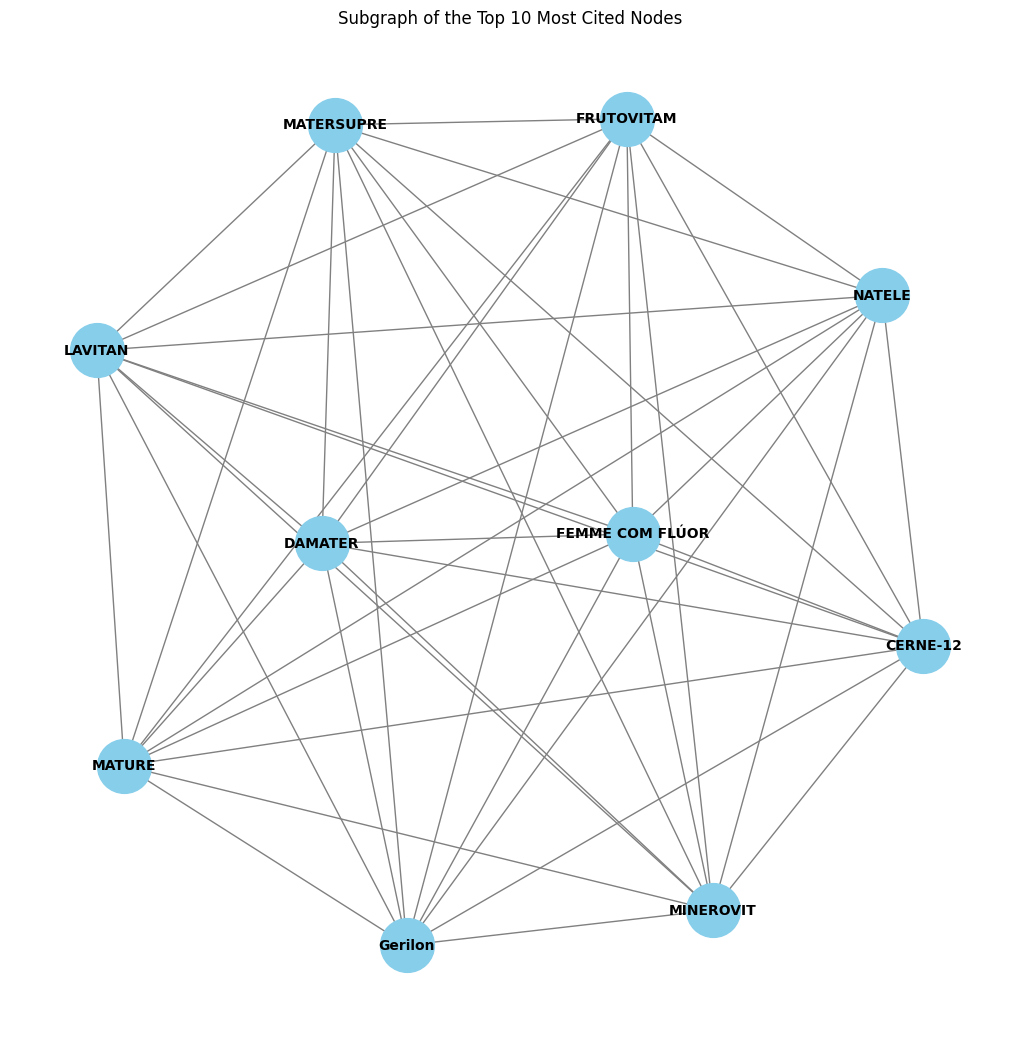

In [ ]:
import matplotlib.pyplot as plt

# Get the degree centrality of each node
degree_centrality = nx.degree_centrality(graph)

# Sort nodes by degree centrality in descending order
sorted_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

# Select the top 10 nodes
top_10_nodes = [node for node, centrality in sorted_nodes[:10]]

# Create a subgraph with only the top 10 nodes and their connections
subgraph = graph.subgraph(top_10_nodes)

# Draw the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Subgraph of the Top 10 Most Cited Nodes")
plt.show()


In [54]:
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 7453
Number of edges: 90718


# Network #02 Bipartite Graph of Medicines and Active Ingredients

Let's calculate the assortativity to answer the following question:

Active ingredients shared by complex medicines tend
to connect to medicines with similar complexity profiles?

In [ ]:
# prompt: Nós (vértices): Medicamentos e princípios ativos são nós distintos. Arestas (Edges): Uma aresta conecta um medicamento aos seus princípios ativos. Assortatividade: Calcular a assortatividade por grau dentro do grafo bipartido para determinar se os princípios ativos que se conectam a medicamentos complexos (com muitos princípios ativos) tendem a se conectar a medicamentos com complexidade semelhant

import networkx as nx
import matplotlib.pyplot as plt

# Create a bipartite graph
graph_bipartite = nx.Graph()

# Add nodes for medicines and active ingredients
for medicine_name, ingredients in medicine_ingredients.items():
    graph_bipartite.add_node(medicine_name, bipartite=0)  # Medicines are in the first partition (0)
    for ingredient in ingredients:
        graph_bipartite.add_node(ingredient, bipartite=1)  # Active ingredients are in the second partition (1)
        graph_bipartite.add_edge(medicine_name, ingredient)

# Calculate degree centrality for each node
degree_centrality = nx.degree_centrality(graph_bipartite)

# Get the nodes related to medicines
medicine_nodes = [node for node, data in graph_bipartite.nodes(data=True) if data['bipartite'] == 0]

# Calculate assortativity by degree
assortativity_degree = nx.degree_assortativity_coefficient(graph_bipartite)
print(f"Assortativity by degree: {assortativity_degree}")

Assortativity by degree: -0.1815341129311202


A positive degree assortativity indicates that nodes with high degree tend to connect to other nodes with high degree. In this context, it suggests that if an active principle is connected to many medications (high degree), then it is more likely to be connected to other medications with many active principles. It implies that principles associated with complex medications tend to be found in other complex medications as well.

A negative degree assortativity indicates that nodes with high degree tend to connect to nodes with low degree. In this context, it suggests that if an active principle is connected to many medications, it is more likely to be connected to medications with fewer active principles. It implies that principles associated with complex medications are more likely to be found in less complex medications.

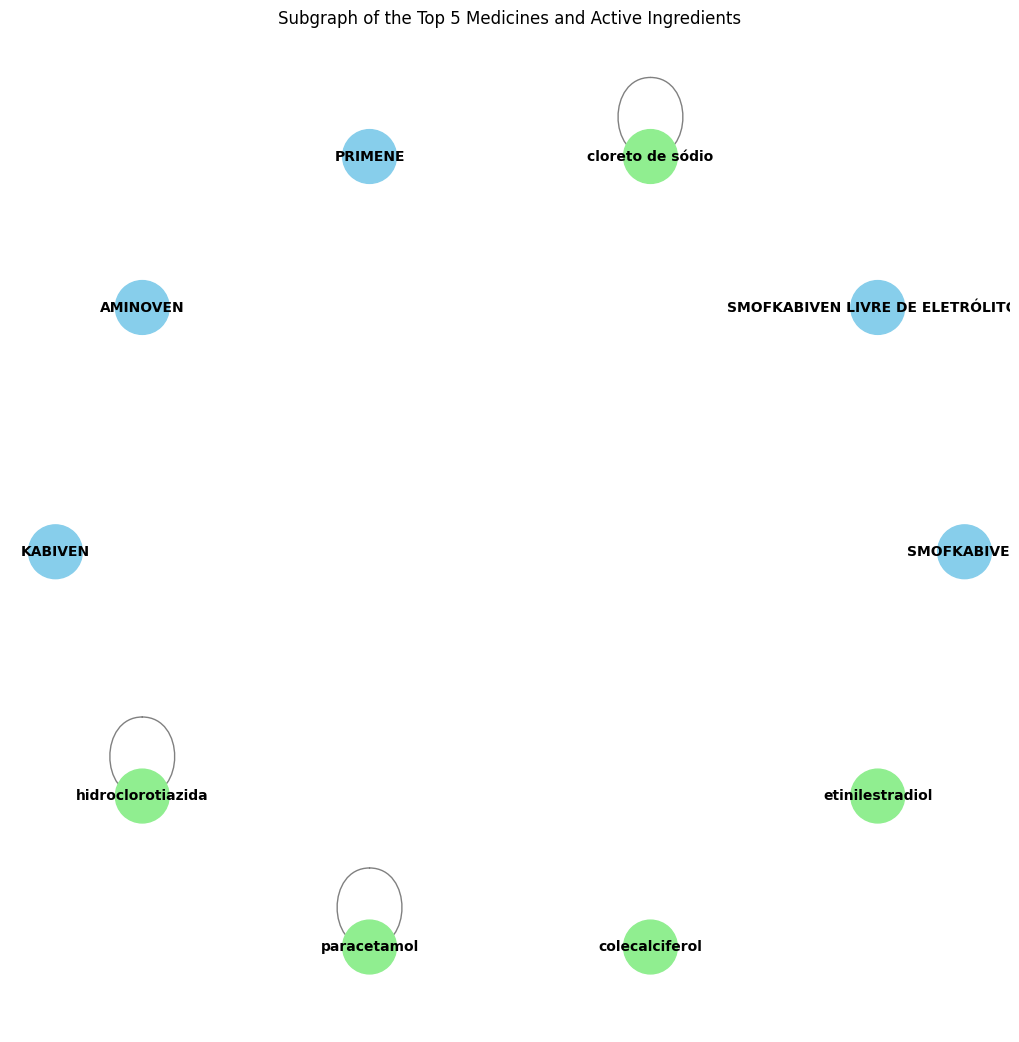

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming medicine_ingredients and graph_bipartite are defined as before

# Get degree centrality for medicine nodes
degree_centrality_medicine = {node: degree_centrality[node] for node in medicine_nodes}

# Sort medicine nodes by degree centrality in descending order
sorted_medicine_nodes = sorted(degree_centrality_medicine.items(), key=lambda item: item[1], reverse=True)

# Select the top 5 medicine nodes
top_5_medicine_nodes = [node for node, centrality in sorted_medicine_nodes[:5]]

# Get the nodes related to active ingredients
ingredient_nodes = [node for node, data in graph_bipartite.nodes(data=True) if data['bipartite'] == 1]

# Calculate degree centrality for ingredient nodes
degree_centrality_ingredient = {node: degree_centrality[node] for node in ingredient_nodes}

# Sort ingredient nodes by degree centrality in descending order
sorted_ingredient_nodes = sorted(degree_centrality_ingredient.items(), key=lambda item: item[1], reverse=True)

# Select the top 5 ingredient nodes
top_5_ingredient_nodes = [node for node, centrality in sorted_ingredient_nodes[:5]]


# Create a subgraph with only the top 5 medicine and ingredient nodes and their connections
subgraph_bipartite = graph_bipartite.subgraph(top_5_medicine_nodes + top_5_ingredient_nodes)

# Draw the subgraph in a circular layout
plt.figure(figsize=(10, 10))
pos = nx.circular_layout(subgraph_bipartite)  # Use circular layout
nx.draw(subgraph_bipartite, pos, with_labels=True, node_color=['skyblue' if graph_bipartite.nodes[node]['bipartite'] == 0 else 'lightgreen' for node in subgraph_bipartite.nodes()],
        node_size=1500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Subgraph of the Top 5 Medicines and Active Ingredients")
plt.show()



# Network #03 Co-occurrence by Company or Therapeutic Class

Let's calculate the assortativity to answer the following question:

Medicines from the same company or therapeutic class tend to
share more active ingredients?

In [49]:
import networkx as nx

# Assuming df_cleaned and medication_ingredients are defined as before

# Create an empty graph
graph = nx.Graph()

# Add nodes (medicines) to the graph
for medicine in medicine_ingredients:
    graph.add_node(medicine, company=df_cleaned.loc[df_cleaned['NOME_PRODUTO'] == medicine, 'EMPRESA_DETENTORA_REGISTRO'].iloc[0],
                  therapeutic_class=df_cleaned.loc[df_cleaned['NOME_PRODUTO'] == medicine, 'CLASSE_TERAPEUTICA'].iloc[0])

# Add edges (connections) between medicines that share active ingredients
for medicine1, ingredients1 in medicine_ingredients.items():
    for medicine2, ingredients2 in medicine_ingredients.items():
        if medicine1 != medicine2:
            if any(ingredient in ingredients2 for ingredient in ingredients1):
                graph.add_edge(medicine1, medicine2)

# Calculate assortativity based on company
assortativity_company = nx.attribute_assortativity_coefficient(graph, 'company')
print(f"Assortativity based on company: {assortativity_company}")

# Calculate assortativity based on therapeutic class
assortativity_therapeutic_class = nx.attribute_assortativity_coefficient(graph, 'therapeutic_class')
print(f"Assortativity based on therapeutic class: {assortativity_therapeutic_class}")

# Interpretation:
# A positive assortativity based on company or therapeutic class means that medications from the same company or therapeutic class tend to share more active principles and be more connected in the network.
# This indicates that companies or therapeutic classes might have a focus on specific active principles or develop medications with similar active principle combinations.
# A negative assortativity would suggest the opposite.


Assortativity based on company: 0.023349165207022498
Assortativity based on therapeutic class: 0.3994411719312235


A positive assortativity based on company or therapeutic class means that medications from the same company or therapeutic class tend to share more active principles and be more connected in the network. This indicates that companies or therapeutic classes might have a focus on specific active principles or develop medications with similar active principle combinations. A negative assortativity would suggest the opposite.

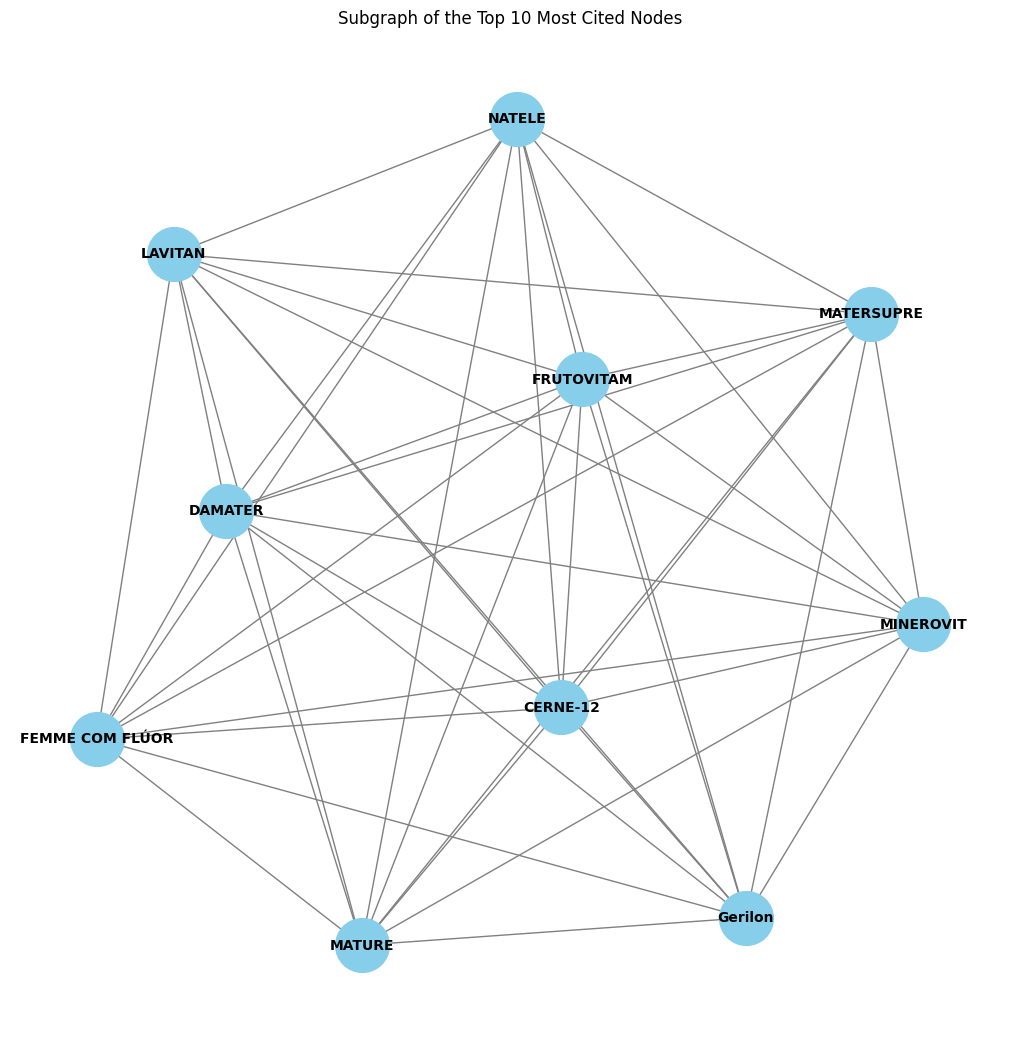

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'graph' is your NetworkX graph from the previous code

# Get the degree centrality of each node
degree_centrality = nx.degree_centrality(graph)

# Sort nodes by degree centrality in descending order
sorted_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

# Select the top 10 nodes
top_10_nodes = [node for node, centrality in sorted_nodes[:10]]

# Create a subgraph with only the top 10 nodes and their connections
subgraph = graph.subgraph(top_10_nodes)

# Draw the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Subgraph of the Top 10 Most Cited Nodes")
plt.show()
